In [1]:
import dataAcquisition as daq
import matplotlib.pyplot as plt
from time import perf_counter,time,sleep
from numpy import median,std
from scipy.io import loadmat

In [2]:
port = '/dev/ttyUSB0'
res = [9.88,10.04,9.83,10,9.97,10]
dur = 7200
step = 1

hal9001 = daq.DAQ(port,res,dur,step)

a = 9.57e-04
b = 3.15e-04
c = -1.17e-05
d = 6.23e-07

Channel 0: 2.468 V
Channel 1: 2.434 V
Channel 2: 2.4535 V
Channel 3: 2.473 V
Channel 4: 2.517 V
Channel 5: 2.556 V
readings nominal


In [3]:
for i in hal9001:
    volt = i.readVoltage()
    res = i.calcResistance(volt)
    temp = i.calcTemperature(res,a,b,c,d)
    print(i,temp)

<dataAcquisition.Channel object at 0x7fe90da83ba8> 26.001393040074902
<dataAcquisition.Channel object at 0x7fe90da83c18> 26.258521808738692
<dataAcquisition.Channel object at 0x7fe90da83d30> 26.386214942766458
<dataAcquisition.Channel object at 0x7fe90da83dd8> 25.631172261558334
<dataAcquisition.Channel object at 0x7fe90da83d68> 24.708188065147056
<dataAcquisition.Channel object at 0x7fe90da83eb8> 24.108555683784573


In [5]:
start_time = time()
timepoints = []
view_time = 5
duration = dur
pause = step

run = True;

counter = 0
while run:
    timepoints.append(time()-start_time)
    current_time = timepoints[-1]
    
    j = 0
    for i in hal9001:
        temp = i.calcTemperature(i.calcResistance(i.readVoltage()),a,b,c,d)
        i.recoValue(counter,temp)
        j+=1
    counter+=1
    
    if(counter%300 == 0):
        hal9001.saveData()
        for i in hal9001:
            volt = i.readVoltage()
            res = i.calcResistance(volt)
            temp = i.calcTemperature(res,a,b,c,d)
            print(i,temp)
        
        
    if timepoints[-1] > duration:
        run=False
        
    sleep(pause)
    
hal9001.cleanData()
hal9001.saveData()

<dataAcquisition.Channel object at 0x7fe90da83ba8> 26.001393040074902
<dataAcquisition.Channel object at 0x7fe90da83c18> 26.258521808738692
<dataAcquisition.Channel object at 0x7fe90da83d30> 26.293817772923717
<dataAcquisition.Channel object at 0x7fe90da83dd8> 25.088763439156025
<dataAcquisition.Channel object at 0x7fe90da83d68> 23.638171672872204
<dataAcquisition.Channel object at 0x7fe90da83eb8> 22.85877795573691
<dataAcquisition.Channel object at 0x7fe90da83ba8> 26.001393040074902
<dataAcquisition.Channel object at 0x7fe90da83c18> 26.166150909205044
<dataAcquisition.Channel object at 0x7fe90da83d30> 26.118393539558497
<dataAcquisition.Channel object at 0x7fe90da83dd8> 25.18059362989362
<dataAcquisition.Channel object at 0x7fe90da83d68> 24.351018779738695
<dataAcquisition.Channel object at 0x7fe90da83eb8> 23.660962803789914
<dataAcquisition.Channel object at 0x7fe90da83ba8> 25.909183983685807
<dataAcquisition.Channel object at 0x7fe90da83c18> 26.073830422582887
<dataAcquisition.Chann

In [16]:
data = loadmat('20190305-2132data.mat')
time = loadmat('timedata.mat')

In [17]:
channels = []
channels.append(data['0'][0])
channels.append(data['1'][0])
channels.append(data['2'][0])
channels.append(data['3'][0])
channels.append(data['4'][0])
channels.append(data['5'][0])
timepoints = time['time'][0]

In [32]:
for i in range(0,len(channels)):
    nonZeroIndex = 0 != channels[i]
    channels[i] = channels[i][nonZeroIndex]

[array([26.00139304, 26.00139304, 26.00139304, ..., 25.5499934 ,
        25.5499934 , 25.63282494]),
 array([26.25852181, 26.25852181, 26.25852181, ..., 25.71424726,
        25.71424726, 25.80637874]),
 array([26.38621494, 26.38621494, 26.38621494, ..., 25.74961637,
        25.74961637, 25.74961637]),
 array([25.53913256, 25.53913256, 25.53913256, ..., 25.08876344,
        25.08876344, 25.08876344]),
 array([24.44254999, 24.44254999, 24.44254999, ..., 24.44254999,
        24.44254999, 24.44254999]),
 array([23.6609628 , 23.47847322, 23.56970417, ..., 23.6609628 ,
        23.6609628 , 23.56970417])]

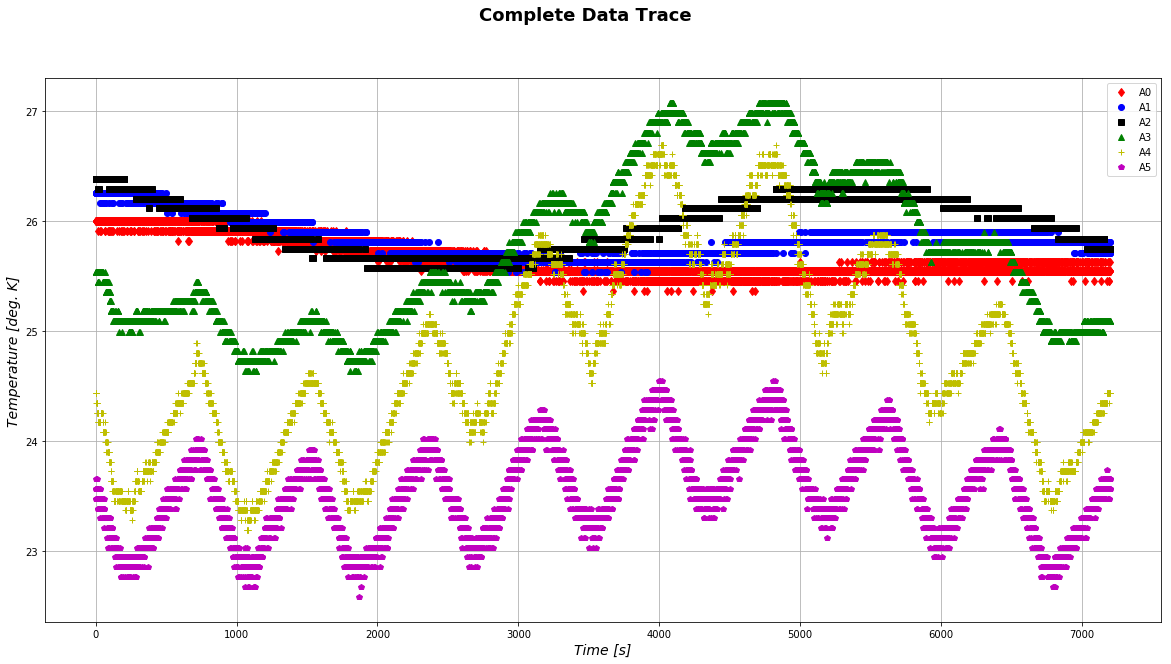

In [35]:
# plot all of the data you collected
fig2 = plt.figure(figsize=(20,10))
# http://matplotlib.org/users/text_props.html
fig2.suptitle('Complete Data Trace', fontsize='18', fontweight='bold')
plt.xlabel('Time [s]', fontsize='14', fontstyle='italic')
plt.ylabel('Temperature [deg. K]', fontsize='14', fontstyle='italic')
plt.axes().grid(True)

styles = ['rd','bo','ks','g^','y+','mp']
labels = ['A0','A1','A2','A3','A4','A5']

for i in range(0,len(channels)):
    plt.plot(timepoints,channels[i],styles[i],label=labels[i])
    
plt.legend()
fig2.show()
fig2.savefig('20190305-2132plot.png')